Let's try running the recently trimmed 84 samples through CNVkit again:

In [ ]:
# terminal

module load cnvkit
exome_targets='/data/NCR_SBRB/simplex/SeqCapEZ_Exome_v3.0_Design_Annotation_files/SeqCap_EZ_Exome_v3_hg19_capture_targets.bed'
ref_fa='/fdb/igenomes/Homo_sapiens/UCSC/hg19/Sequence/WholeGenomeFasta/genome.fa'

cd ~/data/cnv/trimmed/cnvkit
cnvkit.py batch ../BAM/*.bam -n \
    -t $exome_targets -f $ref_fa \
    --access /usr/local/apps/cnvkit/0.9.1/data/access-5k-mappable.hg19.bed \
    --output-reference my_flat_reference.cnn -d flat/ -p 30

I ended up running it in a terminal because the notebook wasn't showing error messages. Also, I had to install with pip a newer version of pysam (--user), because the version in the module was crashing cnvkit.

Before we go ahead with the call command, let's calculate some confidence intervals so we can use as filters in the future too:

In [ ]:
# terminal
cd flat
while read s; do
    cnvkit.py call ${s}.cns -y -m threshold;
    cnvkit.py segmetrics -s ${s}.cn{s,r} --ci;
    cnvkit.py call ${s}.segmetrics.cns -y -m threshold --filter ci;
done < ../../conifer/samples.txt

Time to do the actual analysis in Python:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
import glob
ped_files = ['/data/sudregp/multiplex_simplex/simplex.ped']
wes_prefix = ['CLIA', 'CCGO', 'WPS']
# fid = open('/home/sudregp/data/multiplex_simplex/samples_simplex_all.txt', 'r')
# exclude_list = [line.rstrip() for line in fid]
# fid.close()

# no controls/affected pair for comparison
exclude_list = ['CLIA_400165', 'CLIA_400164', 'CLIA_400155', 'CLIA_400146',
                'CLIA_400145', 'CLIA_400126', 'CLIA_400207', 'CLIA_400208',
                'CLIA_400209']
# missing one parent
exclude_list += ['CLIA_400169', 'CLIA_400168']
# family 9030
exclude_list += ['CCGO_800978', 'CCGO_800977', 'CCGO_800976', 'CCGO_800979',
                 'CCGO_800980', 'CLIA_400067']

trios = []
affected = []
controls = []
samples = []
famids = []
for ped_file in ped_files:
    fid = open(ped_file, 'r')
    for line in fid:
        famid, sid, fa, mo, sex, aff = line.rstrip().split('\t')
        # if the current ID and its parents have WES data, and the sample is 
        # not in yet
        if (fa.split('_')[0] in wes_prefix and
            mo.split('_')[0] in wes_prefix and
            sid.split('_')[0] in wes_prefix and
            sid not in samples and
            (sid not in exclude_list or fa not in exclude_list or mo not in exclude_list)):
            fam = {}
            fam['child'] = sid
            if aff == '1':
                affected.append(sid)
            else:
                controls.append(sid)
            fam['father'] = fa
            fam['mother'] = mo
            fam['famid'] = famid
            trios.append(fam)
            samples += [sid, fa, mo]
            famids.append(famid)
    fid.close()
samples = set(samples)
famids = set(famids)
kids = set(affected + controls)
good_kids = kids

print 'Unique samples:', len(samples)
print 'Unique families:', len(famids)
print 'Unique children:', len(kids)

Unique samples: 84
Unique families: 19
Unique children: 46


In [3]:
def classify_cnvs(cnvs, trios):
    inherited = {}
    denovo = {}
    for trio in trios:
        inherited[trio['child']] = []
        denovo[trio['child']] = []

    # need to filter in chr and type first because ranges repeat for every chr,
    # and inheritance is only true for the same type of CNV
    for chr in ['chr%d' % d for d in range(1, 23)]:
        for cnvtype in ['dup', 'del']:
            for trio in trios:
                kid = [cnv for cnv in cnvs[trio['child']] if (cnv[0] == chr and
                                                              cnv[3] == cnvtype)]
                dad = [cnv for cnv in cnvs[trio['father']] if (cnv[0] == chr and
                                                              cnv[3] == cnvtype)]
                mom = [cnv for cnv in cnvs[trio['mother']] if (cnv[0] == chr and
                                                              cnv[3] == cnvtype)]
                for cnv in kid:
                    is_inherited = False
                    # if CNV start is not within any parents boundary AND
                    #         CNV end is not within any parents boundary
                    # it's denovo
                    for pcnv in dad + mom:
                        if ((cnv[1] >= pcnv[1] or cnv[1] <= pcnv[2]) or
                            (cnv[2] >= pcnv[1] or cnv[2] <= pcnv[2])):
                            is_inherited = True
                    if is_inherited:
                        inherited[trio['child']].append(cnv)
                    else:
                        denovo[trio['child']].append(cnv)
    return denovo, inherited


def write2plink(data, fname, trios):
    fid = open(fname, 'w')
    fid.write('FID\tIID\tCHR\tBP1\tBP2\tTYPE\tSCORE\tSITE\n')
    for sample, cnvs in data.iteritems():
        famid = [trio['famid'] for trio in trios if trio['child'] == sample][0]
        for cnv in cnvs:
            ch = cnv[0].replace('chr', '')
            if cnv[3] == 'del':
                cnvt = '1'
            else:
                cnvt = '3'
            if len(cnv) > 4:
                score = cnv[5]
                site = cnv[4]
            else:
                score, site = ['0', '0']
            fid.write('\t'.join([famid, sample, ch, cnv[1], cnv[2], cnvt,
                                 score, site]) + '\n')
    fid.close()

In [4]:
data_dir = '/data/sudregp/cnv/trimmed/cnvkit/'

cnvs = {}
for sample in samples:
    cnvs[sample] = []
    df = pd.read_table('%s/flat/%s.segmetrics.call.cns' % (data_dir, sample))
    df = df[df.cn != 2]
    for row in df.itertuples():
        if row.cn > 2:
            cnvtype = 'dup'
        else:
            cnvtype = 'del'
        cnvs[sample].append([row.chromosome, str(row.start), str(row.end),
                             cnvtype])

dn, inh = classify_cnvs(cnvs, trios)
write2plink(dn, data_dir + '/denovo.cnv', trios)
write2plink(inh, data_dir + '/inherited.cnv', trios)
tmp_cnv = {}
for sample in cnvs.iterkeys():
    if sample in affected + controls:
        tmp_cnv[sample] = cnvs[sample]
write2plink(tmp_cnv, data_dir + '/all.cnv', trios)

Then run PLINK:

In [ ]:
#terminal
module load plink/1.07
cd /data/sudregp/cnv/trimmed/cnvkit/

cp ~/data/cnv/penncnv/wellknown_region_hg19 bad_regions.list
cp ~/data/cnv/penncnv/glist-hg19 .
cp ~/data/cnv/penncnv/genes.txt .
cp ~/data/cnv/penncnv/hg19_allenBrainGene_trimmed.txt .

for cnvtype in all denovo inherited; do
    cnvname=${cnvtype}.cnv
    plink --cnv-list $cnvname --cnv-make-map --noweb --out ${cnvtype};

    # remove bad regions
    plink --map ${cnvname}.map --fam ~/data/cnv/simplex_nofamid.ped --cnv-list $cnvname \
        --noweb --1 --cnv-exclude bad_regions.list --cnv-overlap .5 \
        --cnv-write --out ${cnvtype}_clean
    plink --cnv-list ${cnvtype}_clean.cnv --cnv-make-map --noweb --1 \
        --out ${cnvtype}_clean

    for qc in '' '_clean'; do
        cnvname=${cnvtype}${qc}.cnv
        # whole burden
        plink --map ${cnvname}.map --fam ~/data/cnv/simplex_nofamid.ped --cnv-list $cnvname \
            --noweb --1 --cnv-check-no-overlap --out ${cnvtype}${qc}_burden;
        # gene sets
        plink --map ${cnvname}.map --fam ~/data/cnv/simplex_nofamid.ped --cnv-list $cnvname \
            --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
            --cnv-subset genes.txt --out ${cnvtype}${qc}_genes;
        plink --map ${cnvname}.map --fam ~/data/cnv/simplex_nofamid.ped --cnv-list $cnvname \
            --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
            --cnv-subset hg19_allenBrainGene_trimmed.txt \
            --out ${cnvtype}${qc}_brainGenes;
        # subtypes only
        for sub in del dup; do
            plink --map ${cnvname}.map --fam ~/data/cnv/simplex_nofamid.ped --cnv-list $cnvname \
            --noweb --1 --cnv-${sub} --out ${cnvtype}${qc}_${sub}Burden;
            # gene sets
            plink --map ${cnvname}.map --fam ~/data/cnv/simplex_nofamid.ped --cnv-list $cnvname \
                --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                --cnv-subset genes.txt --cnv-${sub} \
                --out ${cnvtype}${qc}_${sub}Genes;
            plink --map ${cnvname}.map --fam ~/data/cnv/simplex_nofamid.ped --cnv-list $cnvname \
                --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                --cnv-subset hg19_allenBrainGene_trimmed.txt --cnv-${sub} \
                --out ${cnvtype}${qc}_${sub}BrainGenes;
        done;
    done;
done

It turns out that removing the well-known regions removes everything! So, there's nothing to plot for the clean data:

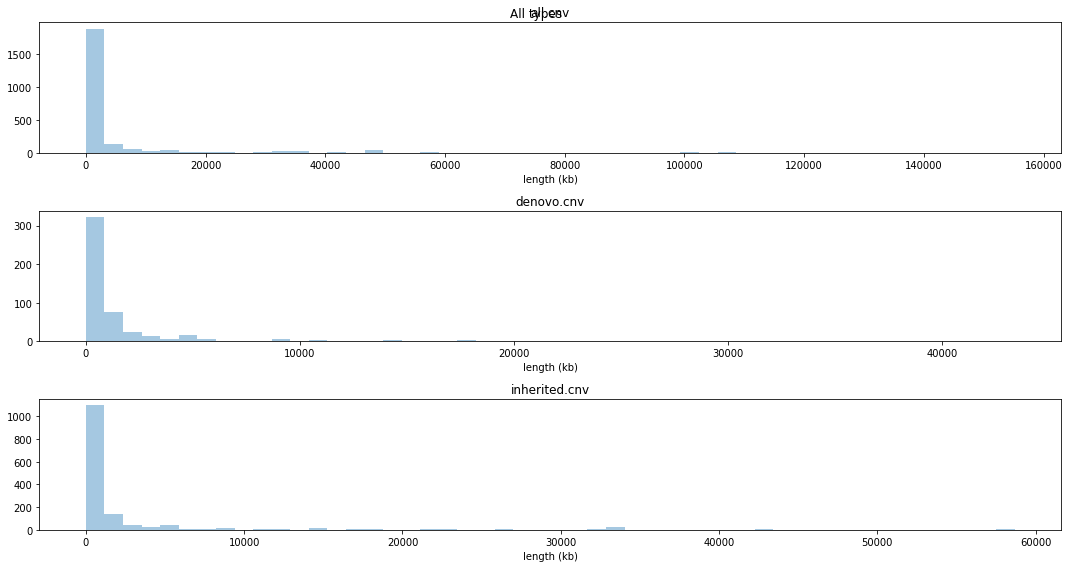

In [8]:
data_dir = '/home/sudregp/data/cnv/trimmed/cnvkit/'
files = glob.glob(data_dir + '/*.cnv')
files.sort()
plt.figure(figsize=(15,8))
i = 1
for fname in files:
    if fname.find('clean') < 0:
        plt.subplot(3, 1, i)
        df = pd.read_table(fname, header=None, skiprows=1, delimiter='\s+')
        sns.distplot((df[4]-df[3])/1000, kde=False, bins=50)
        plt.xlabel('length (kb)')
        plt.title(fname.split('/')[-1])
        i += 1
plt.suptitle('All types')
plt.tight_layout()

In [12]:
%%bash
cd ~/data/cnv/trimmed/cnvkit
cat denovo.cnv | awk '{ if (($5-$4)/1000 > 15000) { print $_, ($5-$4)/1000 } }'

10215	CLIA_400193	9	44869004	65507273	1	0	0 20638.3
1976	CLIA_400204	7	57085422	72744382	3	0	0 15659
10182	CLIA_400172	16	11870178	29577624	3	0	0 17707.4
855	CLIA_400133	16	11870178	29577516	3	0	0 17707.3
10090	CLIA_400195	8	10500	43415889	1	0	0 43405.4
1893	CLIA_400162	5	10500	17498969	1	0	0 17488.5
10033	CLIA_400127	22	24345589	51237655	1	0	0 26892.1


In [13]:
print 'CLIA_400193' in affected
print 'CLIA_400204' in affected
print 'CLIA_400172' in affected
print 'CLIA_400133' in affected
print 'CLIA_400195' in affected
print 'CLIA_400162' in affected
print 'CLIA_400127' in affected

False
True
False
False
False
False
True


No go with the CNV size comparison... let's see the plots:

In [14]:
def plot_plink_cnvs(fname, t_str, verbose=False):
    
    import plotly.graph_objs as go
    from plotly import tools

    df = pd.read_table(fname, delimiter='\s+', index_col=1)
    df.head()

    x_red, x_green, red, green, xticks = [], [], [], [], []
    red_text, green_text = [], []

    # loop through families
    f = 0
    for fam in famids:
        fam_kids = [t['child'] for t in trios if t['famid'] == fam]
        found = False
        for kid in fam_kids:
            if kid in good_kids:
                found = True
                idx = [i for i in range(df.shape[0]) if df.index[i].find(kid) >= 0][0]
                if kid in affected:
                    red.append(int(df.iloc[idx]['NSEG']))
                    x_red.append(f)
                    red_text.append(kid)
                else:
                    green.append(int(df.iloc[idx]['NSEG']))
                    x_green.append(f)
                    green_text.append(kid)
        # only increase counter if we added a kid
        if found:
            xticks.append(fam)
            f += 1

    fig = go.Figure()
                
    trace0 = go.Scatter(
        x = x_red,
        y = red,
        mode = 'markers',
        name = 'affected',
        marker = dict(size = 10, color = 'red'),
        text = red_text,
        hoverinfo='text+y',
        showlegend = True
    )
    trace1 = go.Scatter(
        x = x_green,
        y = green,
        mode = 'markers',
        name = 'unaffected',
        marker = dict(size = 10, color = 'green'),
        hovertext = green_text,
        hoverinfo='text+y',
        showlegend = True
    )
    fig['data'] = [trace0, trace1]
    fig['layout'].update(height=400, width=800, title=t_str,
                             xaxis1=dict(tickvals=range(len(xticks)),
                                        ticktext=xticks,
                                        zeroline = False),
                             hovermode='closest')
    iplot(fig)
    
    # print family order
    if verbose:
        score = []
        for x in range(max(x_green + x_red)):
            idx = [i for i, val in enumerate(x_red) if val == x]
            if len(idx) == 0:
                aff = 0
            else:
                aff = red[idx[0]]
            idx = [i for i, val in enumerate(x_green) if val == x]
            if len(idx) == 0:
                unaff = 0
            else:
                unaff = max([green[i] for i in idx])
            score.append(aff - unaff)
        order = np.argsort(score)[::-1]
        fam_names = fig.layout.xaxis1['ticktext']
        disrupted = [fam_names[v] for v in order if score[v] > 0]
        print 'Best disrupted:', ', '.join(disrupted)
        protected = [fam_names[v] for v in order[::-1] if score[v] < 0]
        print 'Best protected:', ', '.join(protected)

In [15]:
import glob

data_dir = '/home/sudregp/data/cnv/trimmed/cnvkit/'
files = glob.glob(data_dir + '/denovo*.indiv')
files.sort()
for f in files:
    if f.find('clean') < 0:
        t_str = '.'.join(f.split('/')[-1].split('.')[:-2])
        plot_plink_cnvs(f, t_str, verbose=True)

Best disrupted: 
Best protected: 


Best disrupted: 
Best protected: 


Best disrupted: 
Best protected: 


Best disrupted: 
Best protected: 


Best disrupted: 
Best protected: 


Best disrupted: 
Best protected: 


Best disrupted: 
Best protected: 


Best disrupted: 
Best protected: 


Best disrupted: 
Best protected: 


There's something weird here... we should get some blips up...